# Lab 6: Mixture Models + Model order selection

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [31]:
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

class my_GMM():
    
    def __init__(self, k, max_iter=100, eps=1e-5):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        K : int
            number of clusters
        mu_: np.array
            array containing means
        pi_ : (n, ) np.array
            coefficient of each gaussian distribution
        sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        max_iter_ : int
            maximum number of allowed iterations
        eps_ : float
            convergence criterion

        '''
        self.K = k
        self.mu_ = None
        self.pi_ = None
        self.sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        self.max_iter_ = max_iter
        self.eps_ = eps

    def fit(self, X):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        
        _ = self.initialize_clusters(X)            

        # EM algorithm
        LogLL_start = self.log_likelihood(X, self.mu_, self.sigma_, self.pi_, self.K)
        convergence, iter_ = False, 0
        while (not convergence) and iter_ <= self.max_iter_:
            _ = self.expectation_step(X)
            
            _ = self.maximization_step(X)

            LogLL_end = self.log_likelihood(X, self.mu_, self.sigma_, self.pi_, self.K)
            convergence = abs(LogLL_end - LogLL_start) < self.eps_
            LogLL_start = LogLL_end
            iter_ += 1

        self.labels_ = self.cond_prob.argmax(axis=1)
        
        return self
    
    def initialize_clusters(self, X):
        ## Initialisation with Kmeans
        K = self.K
        kmeans = KMeans(n_clusters=K).fit(X)
        self.pi_ = [(kmeans.labels_== k).sum() / X.shape[0] for k in range(K)] # proportion
        self.mu_ = kmeans.cluster_centers_
        self.sigma_ = [np.sum(np.array([(x[:,None]-self.mu_[k][:,None]) @ (x[None,:]-self.mu_[k][None,:]) for x 
                                  in X[kmeans.labels_==k]]), axis=0) / (kmeans.labels_==k).sum() for k in range(K)]
        return self
    
    def expectation_step(self, X):
        W_P = np.array([self.pi_[k] * multivariate_normal.pdf(X, mean=self.mu_[k], cov=self.sigma_[k]) 
                      for k in range(self.K)]).T
        W_P = W_P / np.sum(W_P, axis=1).reshape(-1,1)
        self.cond_prob = W_P
        return self
    
    def maximization_step(self, X):
        n = X.shape[0]
        c_p = self.cond_prob
        self.pi_ = np.sum(c_p, axis=0) / n
        divisor = n*self.pi_
        for k in range(self.K):
            self.mu_[k] = np.sum(c_p[:, k][:,None] * X, axis=0) / divisor[k]
            self.sigma_[k] = np.sum(np.array([c_p[i, k] * (X[[i]].T-self.mu_[k][:,None]) @ 
                                              (X[[i]]-self.mu_[k][None,:]) for i in range(n)]), axis=0) / divisor[k]
        return self
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        probs = self.compute_proba(X)
        return probs.argmax(axis=1)
        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array
        """
        w = np.array([self.pi_[k] * multivariate_normal.pdf(X, mean=self.mu_[k], cov=self.sigma_[k]) for k in range(self.K)]).T
        w = w / np.sum(w, axis=1).reshape(-1, 1)
        return w
    
    @staticmethod
    def log_likelihood(X, mu, sigma, pi, K):
        '''
        Calculates the log likelihood of the model
        '''
        y = np.array([pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k]) for k in range(K)]).T
        return np.sum(np.log(np.sum(y, axis=1)))

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

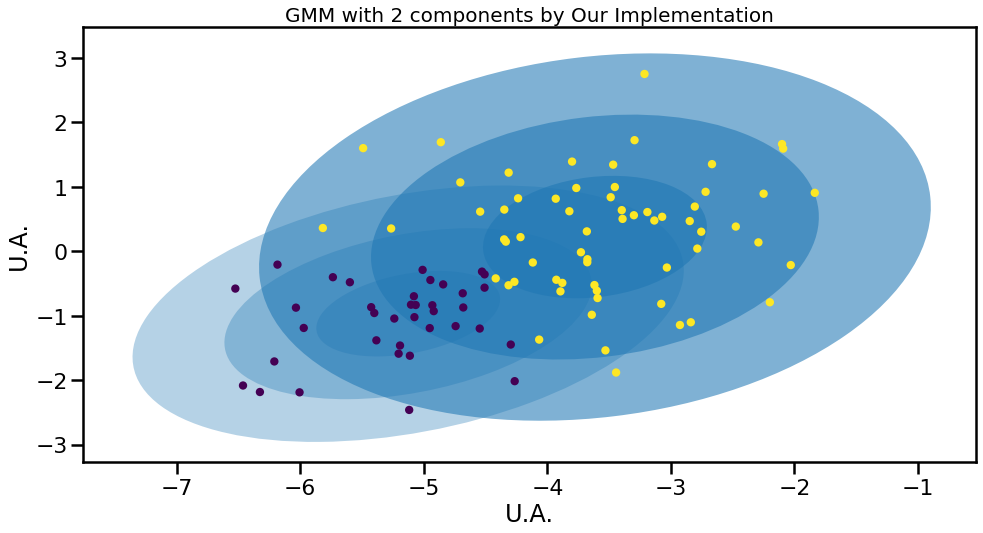

In [42]:
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture as GMM
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 8

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, labels, label=True, ax=None):
    ax = ax or plt.gca()
    labels = labels
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    
    w_factor = 0.2 / gmm.mu_.max()
    for pos, covar, w in zip(gmm.mu_, gmm.sigma_, gmm.pi_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.title("GMM with %d components by Our Implementation"%len(gmm.mu_), fontsize=(20))
    plt.xlabel("U.A.")
    plt.ylabel("U.A.")

def plot_gmm_scikit(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.title("GMM with %d components by Scikit Learn Implementation"%len(gmm.means_), fontsize=(20))
    plt.xlabel("U.A.")
    plt.ylabel("U.A.")

def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

mean = [-4,0]
cov = [[1.2, 0.5], [0.5, 1]]
x = np.random.multivariate_normal(mean, cov, 100)
gmm = my_GMM(k=2)
gmm.fit(x)
labels = gmm.predict(x)
plot_gmm(gmm, x, labels)

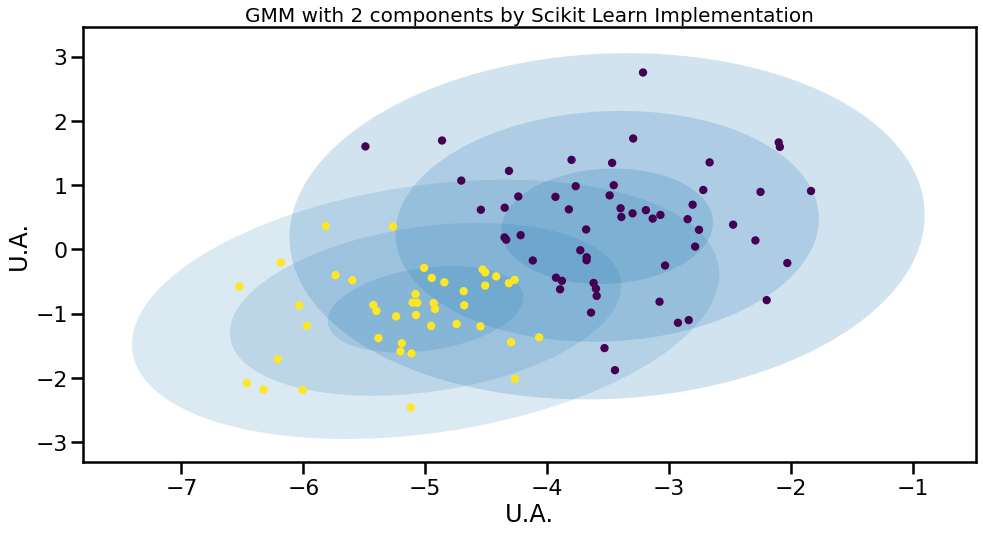

In [43]:
gmm_=GMM(2).fit(x) 
plot_gmm_scikit(gmm_, x)

In [44]:
print('Means by sklearn:\n', gmm_.means_)
print('Means by our implementation:\n', gmm.mu_ )

Means by sklearn:
 [[-3.50811022  0.35803078]
 [-4.99766891 -0.9335505 ]]
Means by our implementation:
 [[-5.1264821  -0.96841693]
 [-3.61499782  0.22097867]]


Well, my implementation doesn't differ much of the sklean one, I think that my code works.

### Comparison with K-Means

Text(0.5, 1.0, 'distribution of the original data')

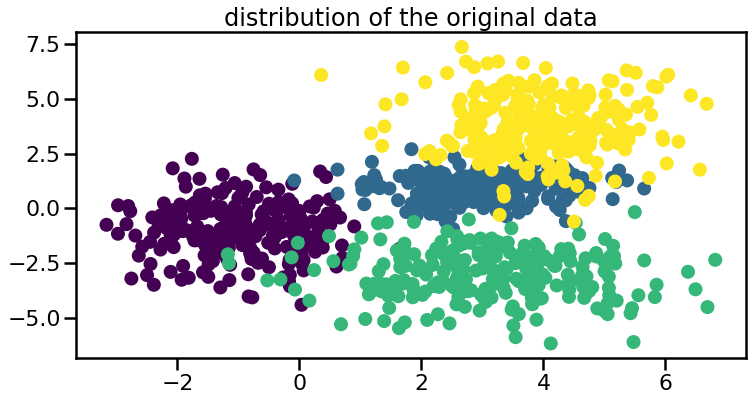

In [77]:
mu = np.array([[-1,-1], [3,1], [3,-3], [4, 4]])
sigma = np.array([np.diag([1, 1.2]), np.diag([1, 0.3]), np.diag([2, 1.3]), np.diag([1.2, 2])])
pi = [1/4, 1/4, 1/4, 1/4]

n_data = 1000


X = np.concatenate([np.random.multivariate_normal(mu[k], sigma[k], size=int(n_data*pi[k])) for k in range(4)], axis=0)
y = np.concatenate([[k] * int(n_data*pi[k]) for k in range(4)])

plt.figure(figsize=(12,6))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('distribution of the original data')

Text(0.5, 1.0, 'Kmeans clustering')

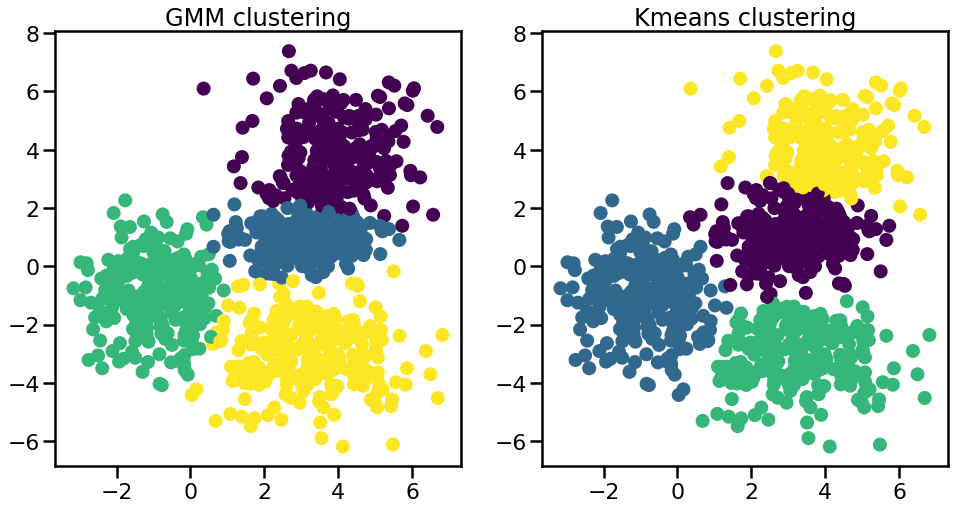

In [78]:
gmm = my_GMM(4).fit(X)
y_gmm = gmm.labels_
kmeans = KMeans(4).fit(X)
y_kmeans = kmeans.labels_

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(X[:, 0], X[:, 1], c=y_gmm)
ax[0].set_title('GMM clustering')
#ax[0].axis(False)

ax[1].scatter(X[:, 0], X[:, 1], c=y_kmeans)
ax[1].set_title('Kmeans clustering')
#ax[1].axis(False)

We can notive that GMM fit better the shape of the cluster yellow and blue (yellow and blue on the original plot above)

### Second Part
 
- Select the number of clusters using the model order selection methods from the lecture (AIC, BIC)

In [93]:
def log_likelihood(X, gmm):
    '''
    Calculates the log likelihood of the model
    '''
    pi, mu, sigma, K = gmm.weights_, gmm.means_, gmm.covariances_, gmm.n_components
    y = np.array([pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k]) for k in range(K)]).T
    return np.sum(np.log(np.sum(y, axis=1)))

def AIC(X, gmm):
    pi, mu, sigma, K = gmm.weights_, gmm.means_, gmm.covariances_, gmm.n_components
    num_param = pi.shape[0] + mu.reshape(-1).shape[0] + sigma.reshape(-1).shape[0]
    return log_likelihood(X, gmm) - num_param

def BIC(X, gmm):
    pi, mu, sigma, K = gmm.weights_, gmm.means_, gmm.covariances_, gmm.n_components
    num_param = pi.shape[0] + mu.reshape(-1).shape[0] + sigma.reshape(-1).shape[0]
    return log_likelihood(X, gmm) - 0.5 * X.shape[0] * np.log(num_param)

Text(0.5, 1.0, 'BIC in data_2')

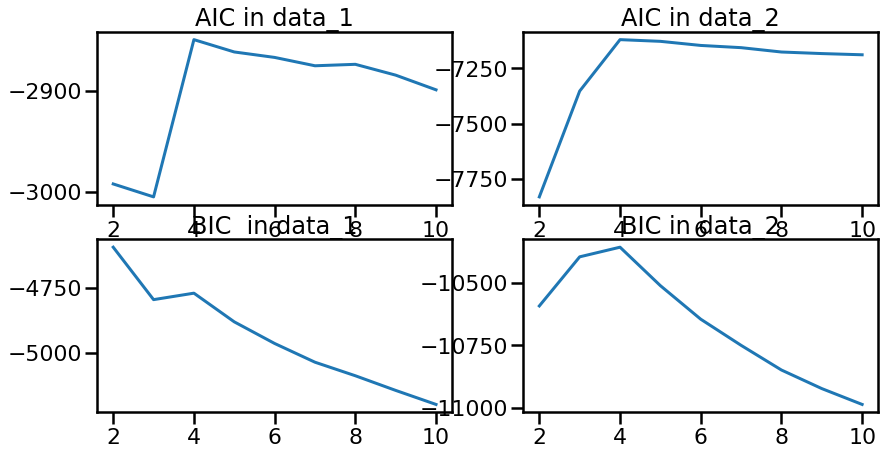

In [94]:
import pandas as pd
X_1 = pd.read_csv('data_MM_1.csv', delimiter=',').values
X_2 = pd.read_csv('data_MM_2.csv', delimiter=',').values

K_candidate = np.arange(2,11)

aic_1 , bic_1 = [], []
aic_2, bic_2 = [], []
for k in K_candidate:
    model = GMM(k).fit(X_1)
    aic_1.append(AIC(X_1, model))
    bic_1.append(BIC(X_1, model))
    model = GMM(k).fit(X_2)
    aic_2.append(AIC(X_2, model))
    bic_2.append(BIC(X_2, model))
    
fig, ax = plt.subplots(2, 2, figsize=(14, 7))
ax[0, 0].plot(K_candidate, aic_1)
ax[0, 0].set_title('AIC in data_1')

ax[0, 1].plot(K_candidate, aic_2)
ax[0, 1].set_title('AIC in data_2')

ax[1, 0].plot(K_candidate, bic_1)
ax[1, 0].set_title('BIC  in data_1')

ax[1, 1].plot(K_candidate, bic_2)
ax[1, 1].set_title('BIC in data_2')

The best number of clusters for X_1 seems to be 4, and same for X_2

- Select the number of clusters using the model order reduction methods from the lecture (distance, correlation and parameter criteria)

**I failed to implement the model order reduction method by correlation(pearson correlation) and parameter criteria (variance comparison)
But I decided to keep the code because I spent so much time on it (even if it's not that good haha)**

In [231]:
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr
import copy

class reduce_model_GMM:
    def __init__(self, model):
        self.model_cr = copy.deepcopy(model)
        self.model_dc = copy.deepcopy(model)
        self.model_pc = copy.deepcopy(model)
    
    def correlation_criterion(self, X, criterion):
        w = self.model_cr.compute_proba(X)
        p = self.model_cr.predict(X)
        pi, mu, sigma, K = self.model_cr.pi_, self.model_cr.mu_, self.model_cr.sigma_, self.model_cr.K
        for i in range(K-1):
            for j in range(i+1, K):
                if pearsonr(w[:, i], w[:, j])[0] > 1 - criterion:
                    pi_new , mu_new, sigma_new = self.new_cluster(i, j, pi, mu, sigma, p)
                    self.model_cr.K -= 1 # Remove one cluster
                    self.model_cr.sigma_ = np.insert(np.delete(sigma, [i,j], axis=0), len(sigma)-2, sigma_new, axis=0)
                    self.model_cr.mu_ = np.insert(np.delete(mu, [i,j], axis=0), len(mu)-2,  mu_new, axis=0)
                    self.model_cr.pi_ = np.insert(np.delete(pi, [i,j], axis=0), len(pi)-2,  pi_new, axis=0)
                    return self.correlation_criterion(X, criterion)
        return self

    def distance_criterion(self, X, criterion):
        p = self.model_dc.predict(X)
        pi, mu, sigma, K = self.model_dc.pi_, self.model_dc.mu_, self.model_dc.sigma_, self.model_dc.K
        for i in range(K-1):
            for j in range(i+1, K):
                if np.linalg.norm(mu[i] - mu[j]) <= criterion :
                    #print('here')
                    pi_new , mu_new, sigma_new = self.new_cluster(i, j, pi, mu, sigma, p)
                    self.model_dc.K -= 1 # Remove one cluster
                    self.model_dc.sigma_ = np.insert(np.delete(sigma, [i,j], axis=0), len(sigma)-2, sigma_new, axis=0)
                    self.model_dc.mu_ = np.insert(np.delete(mu, [i,j], axis=0), len(mu)-2,  mu_new, axis=0)
                    self.model_dc.pi_ = np.insert(np.delete(pi, [i,j], axis=0), len(pi)-2,  pi_new, axis=0)
                    return self.distance_criterion(X, criterion)
        return self
    
    def parameter_criterion(self, X, criterion):
        p = self.model_pc.predict(X)
        pi, mu, sigma, K = self.model_pc.pi_, self.model_pc.mu_, self.model_pc.sigma_, self.model_pc.K
        for i in range(K-1):
            for j in range(i+1, K):
                pi_new , mu_new, sigma_new = self.new_cluster(i, j, pi, mu, sigma, p)
                variance_new = self.variance(X[(p == i) & (p ==j)], np.array([mu_new]))
                variance_i = self.variance(X[(p == i)], np.array([mu[i]]))
                variance_j = self.variance(X[(p == j)], np.array([mu[j]]))
                if variance_new < variance_i + variance_j - criterion :
                    self.model_pc.K -= 1 
                    self.model_pc.sigma_ = np.insert(np.delete(sigma, [i,j], axis=0), len(sigma)-2, sigma_new, axis=0)
                    self.model_pc.mu_ = np.insert(np.delete(mu, [i,j], axis=0), len(mu)-2,  mu_new, axis=0)
                    self.model_pc.pi_ = np.insert(np.delete(pi, [i,j], axis=0), len(pi)-2,  pi_new, axis=0)
                    return self.parameter_criterion(X, criterion)
        return self 

    @staticmethod
    def variance(X, mu):
        return np.sum(distance_matrix(X, mu))
    
    @staticmethod
    def new_cluster(i, j, pi, mu, sigma, p):
        pi_new = pi[i] + pi[j]
        size_i = np.sum(p == i)
        size_j = np.sum(p == j)
        mu_new = (size_i * mu[i] + size_j * mu[j]) / (size_i + size_j)
        sigma_new = (size_i * sigma[i] + size_j * sigma[j]) / (size_i + size_j)
        return pi_new, mu_new, sigma_new

In [208]:
# We began by a large K = 10 
model = my_GMM(k=10).fit(X_1)
reducer_1 = reduce_model_GMM(model)

In [265]:
reducer_1 = reduce_model_GMM(model)

In [225]:
reducer_1.distance_criterion(X_1, criterion=np.mean(model.mu_))
print(f'Number of clusters by distance criterion : {reducer_1.model_dc.K}')

Number of clusters by distance criterion : 4


In [229]:
reducer_1.correlation_criterion(X, criterion=0.25)
# couldn't debug .. :( 

ValueError: operands could not be broadcast together with shapes (1000,2) (3,) 

In [269]:
reducer_1.parameter_criterion(X_1, criterion=200)
print(f'Number of clusters by criterion criterion : {reducer_1.model_pc.K}')

Number of clusters by distance criterion : 1


## Application

You are going to work with the following data:

shape: (1797, 64)


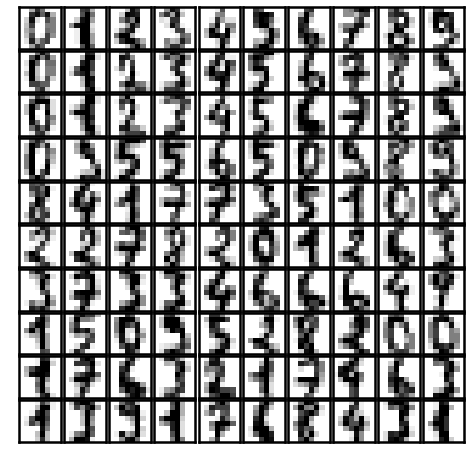

In [271]:
from sklearn.datasets import load_digits
digits = load_digits()
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method to produce new synthetic handwritten numbers. Explain why you used that model selection method in this case. Finally, sample from every class and visualize to get an idea of what each cluster corresponds to. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

In [274]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM

In [275]:
pca = PCA(0.95, whiten=True)
digit_pca = pca.fit_transform(digits.data)
print(digit_pca.shape)

(1797, 29)


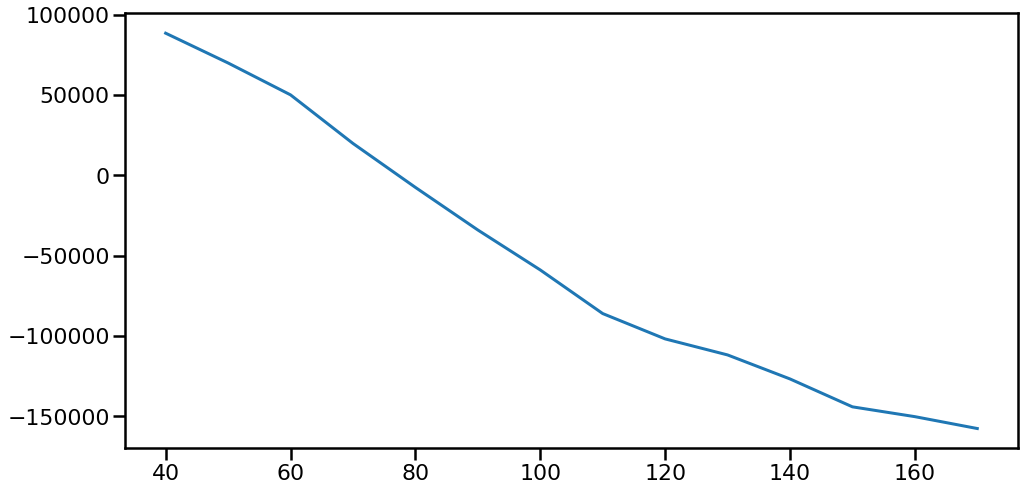

In [278]:
#Printing the AIC curve for all models with components in 40, 30, 40, 50, 60, 70,...,180
n_components = np.arange(40, 180, 10)
models = [GMM(n, random_state=0)
          for n in n_components]
aics = [model.fit(digit_pca).aic(digit_pca) for model in models]
plt.plot(n_components, aics);

Using the Elbow method, we can notice that there is a change when n_component = 110
I used AIC because it well fit the high dimensional data.

In [279]:
gmm = GMM(110, random_state=0)
gmm.fit(digit_pca)

GaussianMixture(n_components=110, random_state=0)

In [281]:
gmm.means_.shape

(110, 29)

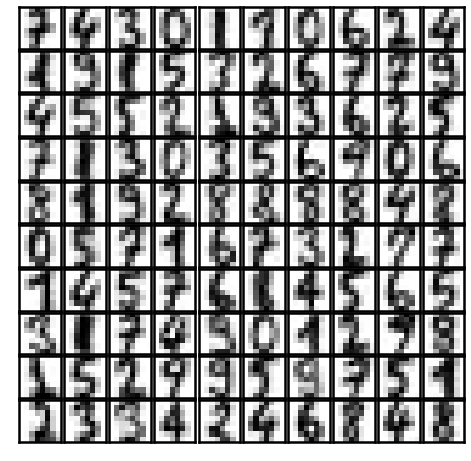

In [283]:
cluster_digit_generated = pca.inverse_transform(gmm.means_)
plot_digits(cluster_digit_generated)

We can see that each cluster correspond to a way of writing a digit.